## 算法流程

如图所示，$\text{Q-learning}$ 算法的核心流程如下：

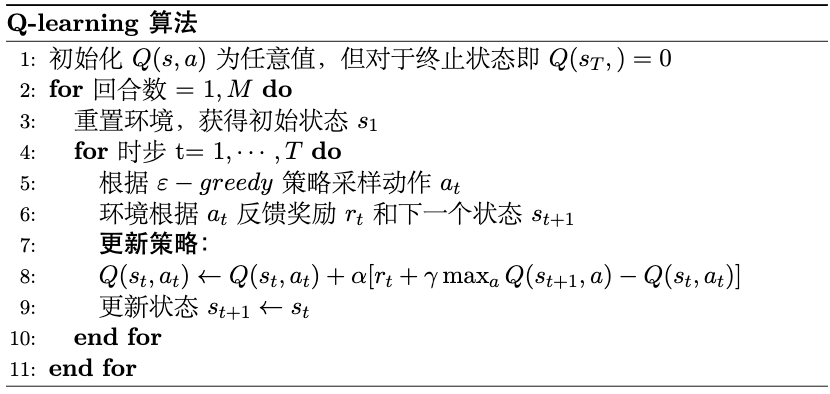

## 定义超参数

为了便于调整和实验，我们把所有的超参数都定义在一个`Python`类中。

In [8]:
class Config:
    def __init__(self) -> None:
        ## 通用参数
        self.env_id = "CliffWalking-v0" # 环境id
        self.n_states = 48 # 状态数
        self.n_actions = 4 # 动作数
        self.render_mode = None # 渲染模式
        self.algo_name = "Qlearning" # 算法名称
        self.seed = 1 # 随机种子
        self.device = "cuda" # 训练设备，"cpu" or "cuda"
        self.max_episode = 300 # 最大回合数
        self.max_step = 200 # 每个回合的最大步数

        ## 算法参数
        self.epsilon_start = 0.95 # epsilon 初始值
        self.epsilon_end = 0.01 # epsilon 终止值
        self.epsilon_decay = 300 # epsilon 衰减率
        self.gamma = 0.90 # 奖励折扣因子
        self.lr = 0.1 # 学习率

## 定义策略

策略决定智能体如何选择动作，即智能体是策略的载体。在实践中，我们用一个类来表示策略，通常包含以下几个部分：

1. 模型：表示策略的函数近似器，例如神经网络或查找表。
2. 采样动作：表示训练模式下如何根据当前状态选择动作，通常包含探索机制。
3. 预测动作：表示测试模式下如何根据当前状态选择动作，由于是用来评估训练好的策略或模型的，一般不包含探索机制。
4. 更新策略：表示如何根据经验数据来更新策略或模型的参数。

在 $\text{Q-learning}$ 算法中，模型即动作价值函数 $Q(s, a)$ 是用表格来表示的，可以用一个二维数组或者字典来实现。对于其他部分包括更新策略等，可以参照算法流程中的公式来依次实现。

In [9]:
import numpy as np
import math
import torch
from collections import defaultdict

class Policy(object):
    def __init__(self, cfg: Config):
        ''' 初始化
        '''
        self.n_actions: int = cfg.n_actions # 动作数
        self.lr: float = cfg.lr 
        self.gamma: float = cfg.gamma    
        self.epsilon: float = cfg.epsilon_start
        self.sample_count = 0  # 采样计数，用于 epsilon 衰减
        self.epsilon_start: float = cfg.epsilon_start 
        self.epsilon_end: float = cfg.epsilon_end
        self.epsilon_decay: float = cfg.epsilon_decay
        self.Q_table = defaultdict(lambda: np.zeros(self.n_actions)) # 使用默认字典来表示 Q(s,a)，初始值为 0

    def sample_action(self, state):
        ''' 采样动作
        ''' 
        self.sample_count += 1
        # epsilon 值需要衰减，衰减方式可以是线性、指数等，以平衡探索和开发
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择具有最大 Q 值的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选择一个动作
        return action
    
    def predict_action(self, state):
        ''' 预测动作
        '''
        action = np.argmax(self.Q_table[str(state)])
        return action
    
    def update(self, state, action, reward, next_state, done):
        ''' 更新策略
        '''
        Q_estimate = self.Q_table[str(state)][action]  # Q 估计值 Q(s,a)
        if done: # TD 更新需考虑终止状态
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        # Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) * (1 - int(done))
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_estimate) 

## 定义工具函数

为了保证实验的可复现性，通常需要固定随机种子。因此，我们定义一个工具函数 `set_seed` 来设置所有相关模块的随机种子。另外，为了更好地观察训练过程中的变化情况，我们定义了一些绘图函数来可视化训练结果。


In [10]:
import random
import os
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def set_seed(seed = 0):
    ''' 固定随机种子
    '''
    if seed == 0: # 不设置随机种子
        return 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards, ylabel = "rewards", title="learning curve"):
    ''' 绘制奖励曲线
    '''
    sns.set_theme()
    plt.figure()  
    plt.title(f"{title}") # 设置标题
    plt.xlim(0, len(rewards)) # x轴范围
    plt.xlabel('episodes') # x轴标签
    plt.ylabel(ylabel) # y轴标签
    plt.plot(rewards, label='original') # 绘制原始奖励曲线
    plt.plot(smooth(rewards), label='smoothed') # 绘制平滑后的奖励曲线
    plt.legend() # 显示图例
    plt.show() 

## 定义环境

我们使用 `gymnasium` 库中的 `CliffWalking-v0` 环境来测试我们的 $\text{Q-learning}$ 算法。这个环境是一个经典的网格世界任务，智能体需要从起点走到终点，同时避免掉入悬崖。状态空间是离散的，共有 48 个状态，表示网格中的每个位置。动作空间也是离散的，共有 4 个动作，分别表示向上、向下、向左和向右移动。

In [11]:
import gymnasium as gym

ACTION_MAP = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}

def create_env(cfg: Config):
    ''' 创建环境并设置随机种子
    '''
    env = gym.make(cfg.env_id, render_mode = cfg.render_mode) # 创建环境
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    print(f"状态数：{n_states}，动作数：{n_actions}")
    return env

## 定义训练与测试

我们按照 $\text{Q-learning}$ 算法的流程来实现训练与测试过程。在训练过程中，智能体通过与环境交互来收集经验数据，并根据这些数据来更新动作价值函数 $Q(s, a)$。在测试过程中，智能体使用训练好的动作价值函数来选择最优动作，从而评估其性能。

In [12]:
import time
def train(cfg: Config, env, policy: Policy):
    ''' 训练
    '''
    print("开始训练！")
    s_t = time.time()
    rewards = []  # 记录所有回合的奖励
    steps = []  # 记录所有回合的步数
    for i_ep in range(cfg.max_episode):
        ep_reward = 0  # 单回合总奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境并获取初始状态
        for _ in range(cfg.max_step):
            ep_step += 1
            action = policy.sample_action(state)  # 采样动作 
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境并返回新状态、奖励、终止状态、截断标志和其他信息（使用 OpenAI Gym 的 new_step_api）
            done = terminated or truncated
            policy.update(state, action, reward, next_state, done)  # 更新策略
            state = next_state  # 更新状态 
            ep_reward += reward 
            ep_step += 1
            if done:
                break
        rewards.append(ep_reward)
        steps.append(ep_step)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.max_episode}，奖励：{ep_reward:.2f}, 步数：{ep_step}")
    env.close()
    print(f"完成训练！用时：{time.time()-s_t:.2f} 秒")
    return {'rewards':rewards, 'steps':steps}

def test(cfg: Config, env, policy: Policy):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    s_t = time.time()
    for i_ep in range(cfg.max_episode):
        ep_reward = 0  # 一轮的累计奖励 
        ep_step = 0
        action_sequence = []
        obs, info = env.reset(seed = cfg.seed)  # 重置环境并获取初始状态
        for _ in range(cfg.max_step):
            action = policy.predict_action(obs)  # 预测动作 
            next_obs, reward, terminated, truncated , info = env.step(action)
            done = terminated or truncated
            obs = next_obs  # 更新状态 
            ep_reward += reward  # 增加奖励
            ep_step += 1
            action_sequence.append(ACTION_MAP[action])
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.max_episode}，奖励：{ep_reward:.2f}, 步数：{ep_step}, 动作序列：{action_sequence}")
    print(f"完成测试！用时：{time.time()-s_t:.2f} 秒")
    env.close()
    return {'rewards':rewards, 'steps':steps}

## 开始训练

定义好以上各个部分后，可以开始训练 $\text{Q-learning}$ 智能体了。训练过程中，我们会记录每一轮的奖励和步数，并在训练结束后进行可视化展示。

状态数：48，动作数：4
开始训练！
回合：10/300，奖励：-125.00, 步数：250
回合：20/300，奖励：-145.00, 步数：290
回合：30/300，奖励：-80.00, 步数：160
回合：40/300，奖励：-57.00, 步数：114
回合：50/300，奖励：-46.00, 步数：92
回合：60/300，奖励：-66.00, 步数：132
回合：70/300，奖励：-55.00, 步数：110
回合：80/300，奖励：-28.00, 步数：56
回合：90/300，奖励：-65.00, 步数：130
回合：100/300，奖励：-27.00, 步数：54
回合：110/300，奖励：-37.00, 步数：74
回合：120/300，奖励：-27.00, 步数：54
回合：130/300，奖励：-32.00, 步数：64
回合：140/300，奖励：-46.00, 步数：92
回合：150/300，奖励：-28.00, 步数：56
回合：160/300，奖励：-29.00, 步数：58
回合：170/300，奖励：-16.00, 步数：32
回合：180/300，奖励：-24.00, 步数：48
回合：190/300，奖励：-23.00, 步数：46
回合：200/300，奖励：-20.00, 步数：40
回合：210/300，奖励：-30.00, 步数：60
回合：220/300，奖励：-18.00, 步数：36
回合：230/300，奖励：-16.00, 步数：32
回合：240/300，奖励：-17.00, 步数：34
回合：250/300，奖励：-13.00, 步数：26
回合：260/300，奖励：-14.00, 步数：28
回合：270/300，奖励：-27.00, 步数：54
回合：280/300，奖励：-20.00, 步数：40
回合：290/300，奖励：-15.00, 步数：30
回合：300/300，奖励：-17.00, 步数：34
完成训练！用时：0.11 秒


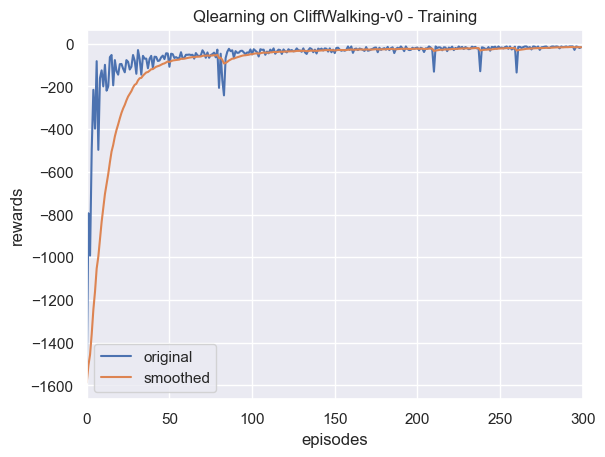

In [13]:

cfg = Config()
set_seed(cfg.seed)
env = create_env(cfg)
policy = Policy(cfg)
train_res = train(cfg, env, policy)
plot_rewards(train_res['rewards'], title=f"{cfg.algo_name} on {cfg.env_id} - Training")

## 开始测试

训练完成后，为了评估智能体的性能，我们进行测试。在测试过程中，智能体使用训练好的动作价值函数来选择最优动作，即不包含探索机制。我们同样会与环境交互，并记录每一轮的奖励和步数，最后进行可视化展示。在复杂环境中，奖励的波动可能较大，而且有时曲线收敛后可能不也不一定代表策略最优（例如奖励设置不当的情况），因此需要渲染环境来直观观察智能体的行为表现。

状态数：48，动作数：4
开始测试！
回合：1/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down']
回合：2/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down']
回合：3/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down']
回合：4/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down']
回合：5/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down']
回合：6/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down']
回合：7/10，奖励：-13.00, 步数：13, 动作序列：['Up', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', '

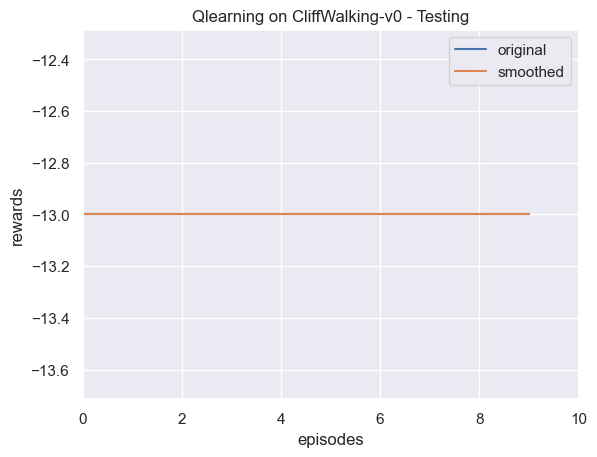

In [14]:
cfg.max_episode = 10 # 测试时只跑10个回合
# cfg.render_mode = 'human' # 测试时渲染环境, 不要在Notebook中开启渲染，会卡死
env_test = create_env(cfg)
test_res = test(cfg, env_test, policy)
plot_rewards(test_res['rewards'], title=f"{cfg.algo_name} on {cfg.env_id} - Testing")